In [5]:
import pyatmos
from pyatmos import coesa76
import numpy as np
import math

In [94]:
def kepler_prop_dragdecay(jd_start, jd_stop, step_size, a, e, i, w, W, V, area, mass, cd):
    """
    Propagates the orbit of a satellite in a Keplerian orbit, taking drag decay into account.
    Uses Kepler's equation for propagation and Gaussian vectors for coordinate transformation.
    Stops the propagation if altitude drops below 200 km.
    """
    # Constants
    r_tol = 1e-7
    GM_earth = 398600.4415
    i, w, W, V = map(np.deg2rad, [i, w, W, V])
    n = np.sqrt(GM_earth / (a**3))
    
    p = a * (1 - (e**2))
    r = p / (1 + e * np.cos(V))
    cos_Eo = ((r * np.cos(V)) / a) + e
    sin_Eo = (r * np.sin(V)) / (a * np.sqrt(1 - e**2))
    Eo = np.arctan2(sin_Eo, cos_Eo) % (2 * np.pi)
    Mo = Eo - e * np.sin(Eo)
    
    # Gaussian vectors
    P, Q = _compute_gaussian_vectors(W, w, i)
    
    t_diff_secs = 86400 * (jd_stop - jd_start)
    steps = math.ceil(t_diff_secs / step_size)
    ephemeris = []

    for step in range(steps):
        # Compute new eccentric anomaly
        E = _compute_eccentric_anomaly(Mo, e, n, step, step_size, r_tol)
        
        # Calculate position and velocity
        x_new, y_new = a * (np.cos(E) - e), a * np.sqrt(1 - e**2) * np.sin(E)
        cart_pos = x_new * P + y_new * Q
        r_new = a * (1 - e * np.cos(E))
        cart_vel = _compute_velocity(GM_earth, a, e, E, P, Q)
        
        ephemeris.append([jd_start + step * step_size / 86400.0, cart_pos.flatten(), cart_vel.flatten()])
        
        # Check altitude and update semi-major axis
        altitude = np.linalg.norm(cart_pos) - 6378.137
        if altitude < 200: break
        
        # Semi-major axis decay due to drag
        a += _sma_drag_decay(cart_pos, cart_vel, cd, area, mass, step_size)
        
    return ephemeris

def _compute_gaussian_vectors(W, w, i):
    P = np.array([
        [np.cos(W) * np.cos(w) - np.sin(W) * np.cos(i) * np.sin(w)], 
        [np.sin(W) * np.cos(w) + np.cos(W) * np.cos(i) * np.sin(w)], 
        [np.sin(i) * np.sin(w)]
    ])
    
    Q = np.array([
        [-np.cos(W) * np.sin(w) - np.sin(W) * np.cos(i) * np.cos(w)], 
        [-np.sin(W) * np.sin(w) + np.cos(W) * np.cos(i) * np.cos(w)], 
        [np.sin(i) * np.cos(w)]
    ])
    return P, Q

def _compute_eccentric_anomaly(Mo, e, n, step, step_size, r_tol):
    Mi = Mo + n * step * step_size
    E = Mi + (e/2) if Mi < np.pi else Mi - (e/2)
    f = E - e * np.sin(E) - Mi
    f_prime = 1 - e * np.cos(E)
    while abs(f/f_prime) > r_tol:
        E -= f/f_prime
        f = E - e * np.sin(E) - Mi
        f_prime = 1 - e * np.cos(E)
    return E

def _compute_velocity(GM_earth, a, e, E, P, Q):
    f_new = np.sqrt(a * GM_earth) / (a * (1 - e * np.cos(E)))
    g_new = np.sqrt(1 - e**2)
    cos_Ei, sin_Ei = np.cos(E) + e, np.sin(E) * np.sqrt(1 - e**2)
    return (-f_new * sin_Ei * P) + (f_new * g_new * cos_Ei * Q)

def _sma_drag_decay(cart_pos, cart_vel, cd, area, mass, step_size):
    GM_earth_m = 398600.4415e9  # in m^3/s^2
    
    r = np.linalg.norm(cart_pos) * 1000  # Convert to meters
    altitude = r - 6378.137e3  # Convert Earth radius to meters
    altitude_km = altitude / 1000
    rho = coesa76(altitude_km).rho  # Atmospheric density
    
    vel_ms = np.linalg.norm(cart_vel) * 1000  # Convert to meters/second
    drag_acc = -(cd * area * rho * vel_ms**2) / (2 * mass)  # Drag acceleration in m/s^2
    
    delta_v = drag_acc * step_size
    
    # Semi-major axis decay by vis-viva equation 
    a_initial = 1 / ((2 / r) - (vel_ms**2 / GM_earth_m)) # Initial semi-major axis in meters
    a_final = 1 / ((2 / r) - ((vel_ms + delta_v)**2 / GM_earth_m)) # Final semi-major axis in meters

    delta_a_m = a_final - a_initial
    delta_a_km = delta_a_m / 1000  # Convert to kilometers
    return delta_a_km


In [95]:
twentytwenty_JD = 2458849.5000000
twentytwenty_JD_plusthree = 2458849.5000000 + 1900
twentytwentythree_JD = 2459945.5000000
twentytwentyone_JD = 2459215.5000000
step_size = 1200000
a = 7080
e = 0.00001
i = 45
w = 70
W = 95
V = 270
area = 10
mass = 100
cd = 2.2

test_prop = kepler_prop_dragdecay(jd_start = twentytwenty_JD, jd_stop= twentytwenty_JD_plusthree, step_size = step_size, a=a, e=e, i=i, w=w, W=W, V=V, area=area, mass=mass, cd=cd)
print(test_prop)

[[2458849.5, array([ 1125.89602279,  6776.94036272, -1712.26091938]), array([-5.19038271,  2.121841  ,  4.98570111])], [2458863.388888889, array([-3692.24363767, -4465.79831016,  4067.4135046 ]), array([ 3.61256873, -5.80405295, -3.09296527])], [2458877.277777778, array([ 4971.27108278,   597.74997378, -5004.45123838]), array([-0.77495518,  7.46249108,  0.12160729])], [2458891.1666666665, array([-4516.70949046,  3478.09191551,  4196.38636298]), array([-2.33301927, -6.51944265,  2.8923483 ])], [2458905.0555555555, array([ 2487.68631612, -6340.86867107, -1925.57679994]), array([ 4.62758469,  3.30275636, -4.89782952])], [2458918.9444444445, array([  408.70168062,  6992.54310074, -1016.58673497]), array([-5.30891481,  1.06552641,  5.19584604])], [2458932.8333333335, array([-3161.91698975, -5206.31894045,  3603.64553523]), array([ 4.13913132, -5.06263309, -3.68214313])], [2458946.722222222, array([ 4812.69663949,  1604.95858011, -4934.26423291]), array([-1.52597902,  7.29455639,  0.88440973

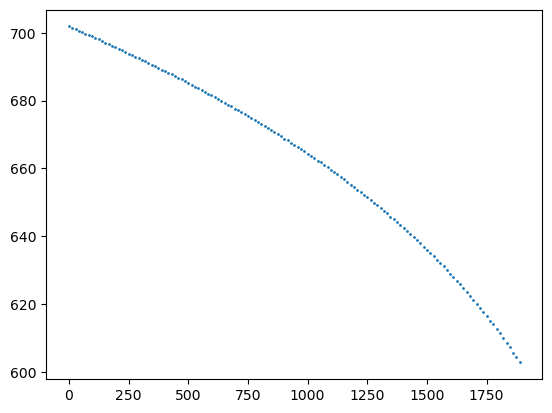

In [96]:
twentytwenty_JD = 2458849.5000000
twentytwenty_JD_plusthree = 2458849.5000000 + 1900

step_size = 1200000
a = 7080
e = 0.00001
i = 45
w = 70
W = 95
V = 270
area = 10
mass = 100
cd = 2.2

test_prop = kepler_prop_dragdecay(jd_start = twentytwenty_JD, jd_stop= twentytwenty_JD_plusthree, step_size = step_size, a=a, e=e, i=i, w=w, W=W, V=V, area=area, mass=mass, cd=cd)

altitudes = []
times = []
for i in range(len(test_prop)):
    altitudes.append(np.linalg.norm(test_prop[i][1])-6378.137)
    times.append(test_prop[i][0])

#convert time to days since propagation start
times = [x - twentytwenty_JD for x in times]

import matplotlib.pyplot as plt
plt.scatter(times, altitudes, s=1)

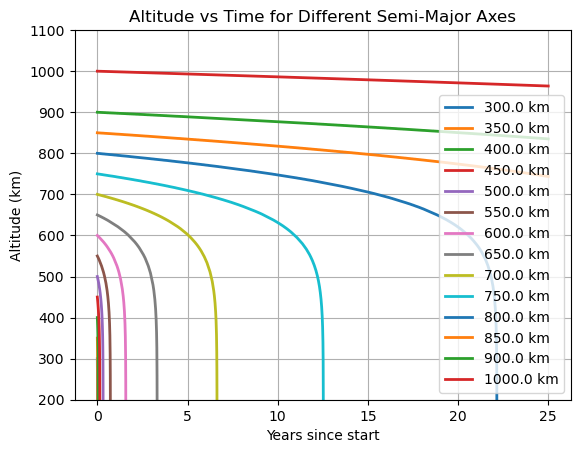

In [111]:
twentytwenty_JD = 2458849.5000000
twentytwenty_JD_plusthree = 2458849.5000000 + 365*25

step_size = 120000
e = 0.00001
i = 45
w = 70
W = 95
V = 270
area = 10
mass = 100
cd = 2.2

altiutude_start = [300,350,400,450,500,550,600,650,700,750,800,850,900,1000]  # List of starting altitudes
smas = [x + 6378.137 for x in altiutude_start]  # Convert to semi-major axes

import matplotlib.pyplot as plt

# Loop over each semi-major axis in the list
for a in smas:
    test_prop = kepler_prop_dragdecay(jd_start = twentytwenty_JD, jd_stop= twentytwenty_JD_plusthree, step_size = step_size, a=a, e=e, i=i, w=w, W=W, V=V, area=area, mass=mass, cd=cd)

    altitudes = []
    times = []
    for i in range(len(test_prop)):
        altitudes.append(np.linalg.norm(test_prop[i][1])-6378.137)
        times.append(test_prop[i][0])

    # Convert time to days since propagation start
    times = [x - twentytwenty_JD for x in times]

    #convert time to years since propagation start
    times = [x/365 for x in times]
    
    # Plot altitude vs. time for each semi-major axis
    plt.plot(times, altitudes, label=f"{a - 6378.137} km", linewidth=2)

# Setting labels, title, and legend
plt.xlabel('Years since start')
plt.ylabel('Altitude (km)')
plt.ylim(200, 1100)
plt.grid()
plt.title('Altitude vs Time for Different Semi-Major Axes')
plt.legend()
plt.show()